In [1]:
import MGTomo.model as mgmodel
import time
import numpy as np
import MGTomo.tomoprojection as mgproj
from MGTomo.utils import myexp, mylog, mydiv
import MGTomo.functions as fcts
from skimage import data
from skimage.transform import resize
from MGTomo.optimize import armijo_linesearch, box_bounds

from MGTomo.gridop import RBox as R, PBox as P

import torch
from torch.func import grad

from torch.linalg import matrix_norm

import matplotlib.pyplot as plt 

In [2]:
max_levels = 3
maxIter = [1,5,5,5,5]

In [3]:
N = 255
# load image
x_orig = data.shepp_logan_phantom()
x_orig = resize(x_orig, (N,N), anti_aliasing = False)

x_torch = torch.tensor(x_orig, requires_grad = True)

In [4]:
model = mgmodel.astra_model(N,{'mode' : 'line', 'num_angles' : 50, 'level_decrease' : 1})
fine_dim = model.dim
A = [mgproj.TomoTorch(model.proj_factory(fine_dim))]
b = [A[0](x_torch)]
level = {int(np.sqrt(A[0].shape[1])): 0}

for i in range(1,max_levels+1):
    coarse_dim = model.reduce_dim(fine_dim)
    A.append(mgproj.TomoTorch(model.proj_factory(coarse_dim)))
    b.append(torch.from_numpy(model.reduce_rhs(b[-1].detach().numpy(), fine_dim, coarse_dim)))
    level.update({int(np.sqrt(A[i].shape[1])): i})
    fine_dim=coarse_dim

In [5]:
#c0 = A[0].sumnorm()
#tau0 = 0.5 * 1/c0

In [6]:
fh = lambda x: fcts.kl_distance(x, A[0], b[0])

In [7]:
#c0 = 56.0952
#tau0 = 0.5 * 1/c0

c0 = 100
tau0 = 0.5 * 1/c0

In [8]:
tau = [tau0]*(max_levels+1)

In [9]:
def coarse_condition_v2(y, grad_y, kappa, eta, y_last = None):
    gcond = (matrix_norm(R(grad_y), ord = 1) >= kappa * matrix_norm(grad_y, ord = 1))
    if y_last is not None:
        y_diff_norm = matrix_norm(y_last - y, ord = 1)
        y_norm = matrix_norm(y, ord = 1)
        return gcond and (y_diff_norm >= eta * y_norm)
    else:
        #print('y_last was none')
        return gcond

In [10]:
def coarse_condition_v3(grad_y, kappa, eps):
    Rgrady = matrix_norm( R(grad_y))
    gcond_rel = (Rgrady >= kappa * matrix_norm(grad_y))
    gcond = (Rgrady >= eps)
    
    return gcond_rel and gcond

In [11]:
def coarse_condition(y, grad_y, kappa, y_last = None):
    gcond = (matrix_norm(0.25 * R(grad_y), ord = 1) >= kappa * matrix_norm(grad_y, ord = 1))
    if y_last is not None:
        y_diff_norm = matrix_norm(y_last - y, ord = 1)
        return gcond and (y_diff_norm >= kappa)
    else:
        return gcond

In [12]:
def MLO_box(fh, y, lh, uh, last_pts: list, l=0, kappa = 0.47, eps = 1e-3, verbose = True):
    x = R(y).detach().requires_grad_(True)
    y0, x0 = y, x.clone().detach().requires_grad_(True)
    
    fhy0 = fh(y0)
    fhy0.backward(retain_graph = True)
    grad_fhy0 = y0.grad.clone()
    y0.grad.zero_()
    
    #print('coarse correction at l = ', l)
    #if coarse_condition(y, grad_fhy0, kappa, last_pts[l]):
    if coarse_condition_v3(grad_fhy0, kappa, eps):
        print(l, ' : coarse correction activated')
        #print('kl(y^*, y^k): ', fcts.kl_distance_no_matrix(x_torch, y0))

        last_pts[l] = y0.clone().detach()
    
        fH = lambda x: fcts.kl_distance(x, A[l+1], b[l+1])
        fHx0 = fH(x0)
        fHx0.backward(retain_graph = True)
        grad_fHx0 = x0.grad.clone()
        x0.grad.zero_()

        kappa = R(grad_fhy0) - grad_fHx0

        psi = lambda x: fH(x) + torch.sum(kappa * x)
        lH, uH = box_bounds(y0, x, P_inf, lh, uh)

        assert torch.all((uH - lH) >= 0)

        logvH_new = mylog(x - lH) - mylog(uH - x)
        assert not torch.any(torch.isnan(logvH_new))
        for i in range(maxIter[l]):
            x.retain_grad()
            val, logvH_new = fcts.BSMART_general(psi, x, logvH_new, tau[l+1], lH, uH)
            x = val.clone().detach().requires_grad_(True)
            
        if l < max_levels-1:
            x, last_pts, _ = MLO_box(psi, x,lH, uH, last_pts, l+1, verbose=verbose)

        #assert psi(x) <= fH(x0) + torch.sum(kappa * x0), 'psi(x) < psi(x0) = fH(x0) does not hold'
    else: 
        print(l, ' : coarse correction not activated')
    
    #print('back on level: ', l)
    d = P(x-x0)
    z, a = armijo_linesearch(fh, y0, d)

    logvh_new = mylog(z - lh) - mylog(uh - z)
    
    for i in range(maxIter[l]):
        z.retain_grad()
        zval, logvh_new = fcts.BSMART_general(fh, z, logvh_new, tau[l], lh, uh)
        y0.grad.zero_()
        z = zval.clone().detach().requires_grad_(True)
    #print('kl(y^*, y^k+1): ', fcts.kl_distance_no_matrix(x_torch, z))
    return z, last_pts, a


In [13]:
P_inf = 1
a = []
z0 = torch.rand(N, N, requires_grad = True)
w0 = z0.clone().detach().requires_grad_(True)
fhz0 = fh(z0).item()
last_pts = [None]*(max_levels+1)

lh = torch.zeros_like(z0)
uh = torch.ones_like(z0)


iteration_times_ML = []
overall_start_time_ML = time.process_time()  # Start overall timing

fval_ML = []

for i in range(100):
    iteration_start_time_ML = time.process_time()  # Start timing for this iteration
    
    val, ylast, alpha = MLO_box(fh, z0, lh, uh, last_pts, verbose=False)
    z0 = val.clone().detach().requires_grad_(True)
    a.append(alpha)
    
    iteration_end_time_ML = time.process_time()  # End timing for this iteration
    iteration_time_ML = iteration_end_time_ML - iteration_start_time_ML  # Calculate elapsed time for this iteration
    iteration_times_ML.append(iteration_time_ML)

    fval_ML.append(fh(z0).detach().numpy()/fhz0)
    
    print(f"Iteration {i}: {fh(z0)} - Time: {iteration_time_ML:.6f} seconds")

overall_end_time_ML = time.process_time()  # End overall timing
overall_time_ML = overall_end_time_ML - overall_start_time_ML  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_ML:.6f} seconds")

cumaltive_times_ML = [sum(iteration_times_ML[:i+1]) for i in range(len(iteration_times_ML))]

0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
Iteration 0: 172139.49354940947 - Time: 29.831822 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
Iteration 1: 125567.23809264303 - Time: 31.915251 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
Iteration 2: 93082.05658350373 - Time: 33.175301 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
Iteration 3: 70113.6573219034 - Time: 32.123166 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
Iteration 4: 53735.538553674574 - Time: 32.825275 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
Iteration 5: 41972.38664315324 - Time: 32.003295 seconds
0  : coarse correction activated
1  : coarse correction activa

In [14]:
iteration_times_SL = []
overall_start_time_SL = time.process_time()  # Start overall timing

fval_SL = []

logv_new = (w0 - lh) / (uh - w0)

for i in range(100):
    iteration_start_time_SL = time.process_time()  # Start timing for this iteration
    
    val, logv_new = fcts.BSMART_general(fh, w0, logv_new, tau0, lh, uh)
    w0 = val.clone().detach().requires_grad_(True)
    
    iteration_end_time_SL = time.process_time()  # End timing for this iteration
    iteration_time_SL = iteration_end_time_SL - iteration_start_time_SL  # Calculate elapsed time for this iteration
    iteration_times_SL.append(iteration_time_SL)

    fval_SL.append(fh(w0).item()/fhz0)
    
    print(f"Iteration {i}: {fh(w0)} - Time: {iteration_time_SL:.6f} seconds")

overall_end_time_SL = time.process_time()  # End overall timing
overall_time_SL = overall_end_time_SL - overall_start_time_SL  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_SL:.6f} seconds")
cumaltive_times_SL = [sum(iteration_times_SL[:i+1]) for i in range(len(iteration_times_SL))]


Iteration 0: 1742494.4428846664 - Time: 2.457088 seconds
Iteration 1: 1122329.507669331 - Time: 2.381122 seconds
Iteration 2: 846922.2010437656 - Time: 2.020007 seconds
Iteration 3: 670722.5661678133 - Time: 2.193252 seconds
Iteration 4: 544487.8564404357 - Time: 1.777255 seconds
Iteration 5: 449975.9927454297 - Time: 2.459065 seconds
Iteration 6: 377287.3861607429 - Time: 1.793415 seconds
Iteration 7: 320461.72280168295 - Time: 2.210601 seconds
Iteration 8: 275468.8054631116 - Time: 2.004294 seconds
Iteration 9: 239373.8812769453 - Time: 1.852561 seconds
Iteration 10: 210111.62741956598 - Time: 2.347114 seconds
Iteration 11: 186359.74044553883 - Time: 1.774173 seconds
Iteration 12: 167026.46687659953 - Time: 2.322824 seconds
Iteration 13: 151103.23375006457 - Time: 1.783008 seconds
Iteration 14: 137832.28531096643 - Time: 2.045690 seconds
Iteration 15: 126667.71216130612 - Time: 2.183075 seconds
Iteration 16: 117186.61502370253 - Time: 1.777278 seconds
Iteration 17: 109051.73257104235

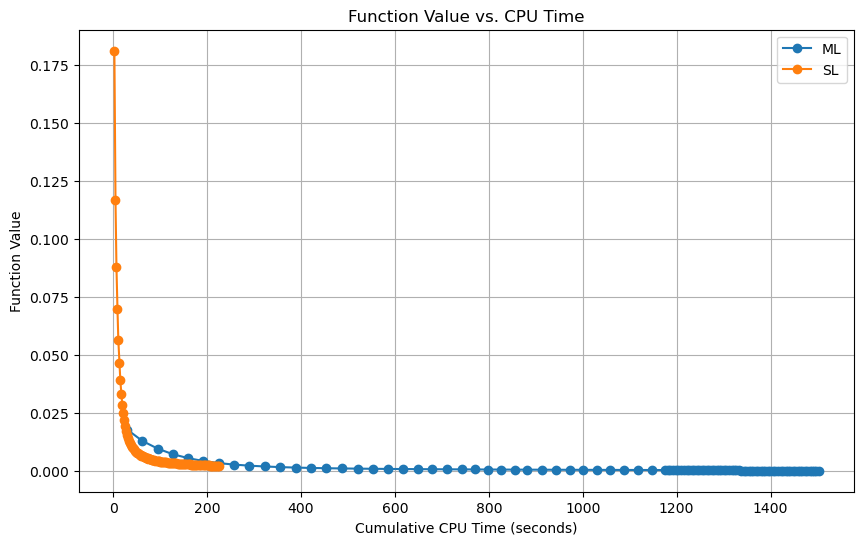

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(cumaltive_times_ML, fval_ML, marker='o', linestyle='-', label = 'ML')
plt.plot(cumaltive_times_SL, fval_SL, marker='o', linestyle='-', label = 'SL')
plt.xlabel('Cumulative CPU Time (seconds)')
plt.ylabel('Function Value')
plt.title('Function Value vs. CPU Time')
plt.grid(True)
plt.legend()
plt.show()

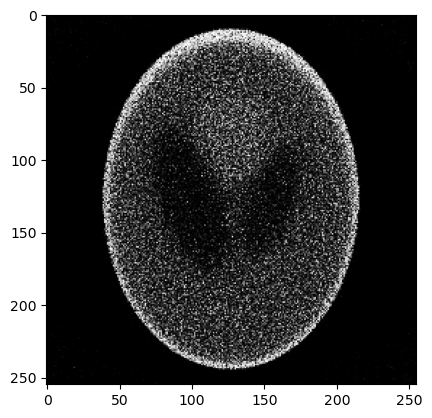

In [16]:
plt.imshow(z0.detach().numpy(), cmap = 'gray')